In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.autograd import Function
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import random
from PIL import Image

from skimage.io import imsave, imread
from skimage.transform import resize
from skimage.transform import rotate
import h5py
import argparse

In [2]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd '/content/gdrive/My Drive/Colab Notebooks/Segmentation/Data'

/content/gdrive/My Drive/Colab Notebooks/Segmentation/Data


<h2> 1. Data Preprocessing

In [4]:
hf = h5py.File('Ultrasound_segmentation.h5', 'r')
[key for key in hf.keys()]

['imgs', 'masks']

In [0]:
imgs = hf.get('imgs')
masks = hf.get('masks')

In [6]:
imgs.shape

(5635, 420, 580)

In [7]:
masks.shape

(5635, 420, 580)

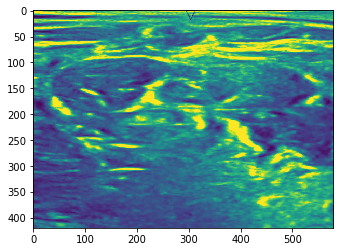

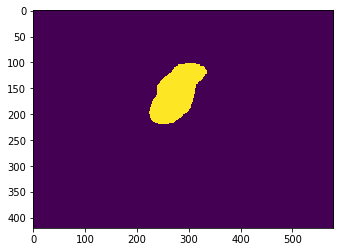

In [8]:
plt.figure()
plt.imshow(imgs[0])
plt.figure()
plt.imshow(masks[0])

In [0]:
img_rows = 96
img_cols = 96

def imgs_resize(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.float32)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_rows, img_cols), preserve_range=True)

    return imgs_p

In [0]:
def norm_imgs(imgs):
  imgs = imgs.astype('float32')
  mean = np.mean(imgs)
  std = np.std(imgs)
  
  imgs -= mean
  imgs /= std
  
  return imgs

def norm_masks(masks):
  masks = masks.astype('float32')
  masks /= 255
  
  return masks

In [0]:
imgs = imgs_resize(imgs)
masks = imgs_resize(masks)

In [0]:
imgs = norm_imgs(imgs)
masks = norm_masks(masks)

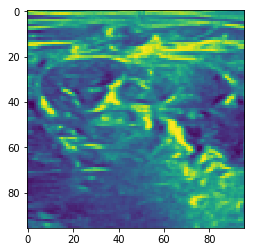

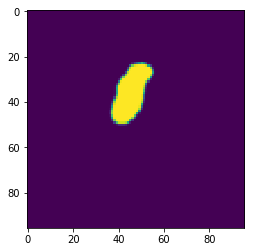

In [13]:
plt.figure()
plt.imshow(imgs[0])
plt.figure()
plt.imshow(masks[0])

In [0]:
# Expand Dims
imgs = imgs[..., np.newaxis]
masks = masks[..., np.newaxis]

In [0]:
# Channel first
imgs = imgs.transpose(0, 3, 1, 2) # C x H x W format
masks = masks.transpose(0, 3, 1, 2)

In [0]:
# Numpy to tensor
imgs = torch.from_numpy(imgs)
masks = torch.from_numpy(masks)

In [0]:
imgs_train = imgs[:4000]
masks_train = masks[:4000]

imgs_val = imgs[4000:4560]
masks_val = masks[4000:4560]

imgs_test = imgs[4560:]
masks_test = masks[4560:]

In [0]:
imgs_train_N = TensorDataset(imgs_train, masks_train)
imgs_val_N = TensorDataset(imgs_val, masks_val)
imgs_test_N = TensorDataset(imgs_test, masks_test)

<h3> # 본인만의 Augmentation을 만들어 보세요!

<h2> 2. Model Architecture

In [0]:
# from https://github.com/jakeoung/Unet_pytorch

import torch
import torch.nn as nn
import torch.nn.functional as functional

def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

def add_merge_stage(ch_coarse, ch_fine, in_coarse, in_fine, upsample):
  conv = nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False)
  torch.cat(conv, in_fine)

  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False)
  )
  upsample(in_coarse)

def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )

class UNet(nn.Module):
  def __init__(self, useBN=False):
    super(UNet, self).__init__()

    self.conv1   = add_conv_stage(1, 32, useBN=useBN)
    self.conv2   = add_conv_stage(32, 64, useBN=useBN)
    self.conv3   = add_conv_stage(64, 128, useBN=useBN)
    self.conv4   = add_conv_stage(128, 256, useBN=useBN)
    self.conv5   = add_conv_stage(256, 512, useBN=useBN)

    self.conv4m = add_conv_stage(512, 256, useBN=useBN)
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)

    self.conv0  = nn.Sequential(
        nn.Conv2d(32, 1, 3, 1, 1),
        nn.Sigmoid()
    )

    self.max_pool = nn.MaxPool2d(2)

    self.upsample54 = upsample(512, 256)
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)

    ## weight initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()


  def forward(self, x):
    conv1_out = self.conv1(x)
    #return self.upsample21(conv1_out)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))
    conv5_out = self.conv5(self.max_pool(conv4_out))

    conv5m_out = torch.cat((self.upsample54(conv5_out), conv4_out), 1)
    conv4m_out = self.conv4m(conv5m_out)

    conv4m_out_ = torch.cat((self.upsample43(conv4m_out), conv3_out), 1)
    conv3m_out = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out = self.conv1m(conv2m_out_)

    conv0_out = self.conv0(conv1m_out)

    return conv0_out

In [0]:
def dimension_check():
    Unet = UNet(useBN=True)
    x = torch.randn(32, 1, 96, 96)
    y = Unet(x)
    print(y.size())

In [21]:
dimension_check()

torch.Size([32, 1, 96, 96])


In [0]:
# Parameters setting
parse = argparse.ArgumentParser()
args = parse.parse_args("")

args.device  = 'cuda' if torch.cuda.is_available() else 'cpu'
args.act = 'relu'
args.optim = 'Adam'
args.lr = 0.001
args.l2 = 0.00001
args.epoch = 30
args.train_batch_size = 32
args.val_batch_size = 32
args.test_batch_size = 32

#model
model = UNet(useBN=True).to(args.device)

#optimization
if args.optim == 'Adam':
    op = optim.Adam(model.parameters(), lr=args.lr, weight_decay = args.l2)
elif args.optim == 'RMSprop':
    op = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
else:
    raise ValueError('Optimiser Error!!')

#Loss
smooth = 1
def dice_coef(y_pred, y_true):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)


def criterion(y_pred, y_true):
    return -dice_coef(y_pred, y_true)
  
parts = {'train':imgs_train_N, 'val':imgs_val_N}

<h2> 3. Train & Evaluation Functions

In [0]:
def train(model, op, criterion, args):
    for epoch in range(args.epoch):
        for part in parts:
            loss_sum = 0
            if part == 'train':
                loader = torch.utils.data.DataLoader(parts['train'], batch_size=args.train_batch_size, shuffle = True, num_workers=2)
                model.train()
            else:
                loader = torch.utils.data.DataLoader(parts['val'], batch_size=args.val_batch_size, shuffle = True, num_workers=2)
                model.eval()
                
            for Inputs, Labels in loader:
                Inputs = Variable(Inputs.to(args.device))
                Labels = Variable(Labels.to(args.device))
                
                Outputs = model(Inputs)
            
                loss = criterion(Outputs, Labels)
                loss_sum += loss.item() # 1개의 원소를 가진 Tensor를 Python의 Scalar로 만들 때는 .item()함수를 사용한다.
                
                op.zero_grad()    
                if part == 'train':
                    loss.backward()
                    op.step()
            print('{} - epoch : {}, loss : {:2.2f}'.format(part, epoch+1, loss_sum/len(loader)))

In [24]:
train(model, op, criterion, args)

train - epoch : 1, loss : -0.24
val - epoch : 1, loss : -0.58
train - epoch : 2, loss : -0.56
val - epoch : 2, loss : -0.67
train - epoch : 3, loss : -0.59
val - epoch : 3, loss : -0.66
train - epoch : 4, loss : -0.61
val - epoch : 4, loss : -0.63
train - epoch : 5, loss : -0.61
val - epoch : 5, loss : -0.68
train - epoch : 6, loss : -0.62
val - epoch : 6, loss : -0.66
train - epoch : 7, loss : -0.63
val - epoch : 7, loss : -0.67
train - epoch : 8, loss : -0.64
val - epoch : 8, loss : -0.69
train - epoch : 9, loss : -0.63
val - epoch : 9, loss : -0.66
train - epoch : 10, loss : -0.65
val - epoch : 10, loss : -0.67
train - epoch : 11, loss : -0.65
val - epoch : 11, loss : -0.69
train - epoch : 12, loss : -0.66
val - epoch : 12, loss : -0.66
train - epoch : 13, loss : -0.67
val - epoch : 13, loss : -0.68
train - epoch : 14, loss : -0.66
val - epoch : 14, loss : -0.66
train - epoch : 15, loss : -0.67
val - epoch : 15, loss : -0.69
train - epoch : 16, loss : -0.67
val - epoch : 16, loss : 

In [0]:
# save
Path = './weight_segmentation_v1.pt'
torch.save(model.state_dict(), Path)

In [0]:
#load
model = UNet(useBN=True).to(args.device)
model.load_state_dict(torch.load("weight_segmentation_v1.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [26]:
from torchvision.transforms import RandomCrop, Compose, ToPILImage

testloader = torch.utils.data.DataLoader(imgs_test_N, batch_size=args.test_batch_size, shuffle = False, num_workers=2)
Loss_sum = 0

for t, (x, y) in enumerate(testloader):
  x = Variable(x).to(args.device)
  y = Variable(y).to(args.device)

  outputs = model(x)

  loss = dice_coef(y, outputs)
  loss = loss.to(args.device)
  
  Loss_sum += loss.item()
  
  x = x.data.type(torch.FloatTensor)
  y = y.data.type(torch.FloatTensor)
  outputs = outputs.data.type(torch.FloatTensor)
  if t == 0 :
    Images = x.cpu().numpy().transpose(1,0,2,3)[0]
    Masks = y.cpu().numpy().transpose(1,0,2,3)[0]
    Results = outputs.cpu().numpy().transpose(1,0,2,3)[0]
  else :
    Images = np.concatenate((Images, x.cpu().numpy().transpose(1,0,2,3)[0]), axis=0)
    Masks = np.concatenate((Masks, y.cpu().numpy().transpose(1,0,2,3)[0]), axis=0)
    Results = np.concatenate((Results, outputs.cpu().numpy().transpose(1,0,2,3)[0]), axis=0)

print("{:2.2f}%".format(Loss_sum/(t+1)*100))

38.66%


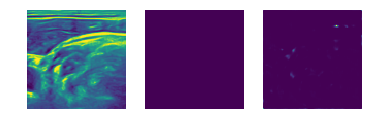

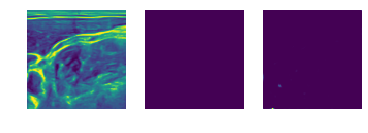

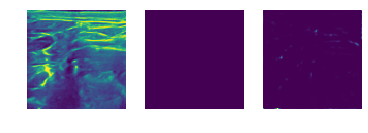

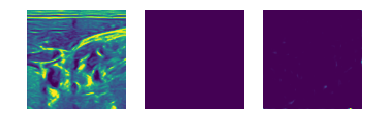

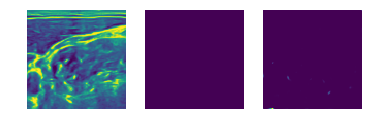

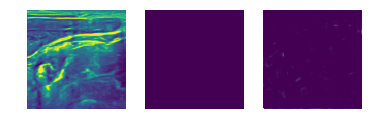

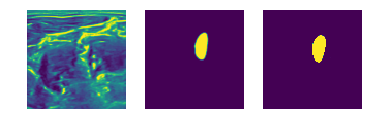

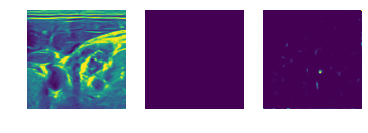

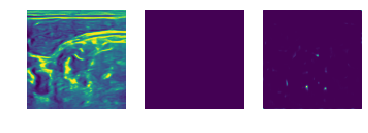

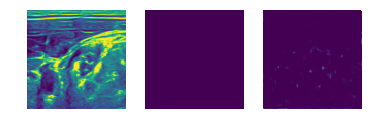

In [27]:
for i in range(50,60):
  plt.figure()
  plt.subplot(1,3,1)
  plt.imshow(Images[i])
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.imshow(Masks[i])
  plt.axis('off')
  plt.subplot(1,3,3)
  plt.imshow(Results[i])
  plt.axis('off')